In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# print(f"CUDA version: {torch.version.cuda}")
 
# cuda_id = torch.cuda.current_device()
# print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
# print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Using device: cpu


c:\Users\cp\anaconda3\Lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### play game func

In [2]:
import numpy as np
import torch
from agent import Agent
from board import Board
from model import ConnectFourNN

def play_exp_game(agent1:Agent, agent2:Agent, type = 'greedy', eps = 0):
    """
    # Returns:
    list of experience from the game from both players
    """

    board = Board()
    agent1.board = board
    agent2.board = board
    curr_agent = agent2
    done = False

    states = []
    actions = []
    rewards = []
    dones = []

    while not done:
        curr_agent = agent1 if curr_agent != agent1 else agent2

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='greedy', eps=eps)
        reward = curr_agent.perform_action(action)
        
        # update previous player if he lost or drew
        if reward == Board.rewards_dict['win']:
            rewards[-1] = Board.rewards_dict['loss']
            dones[-1] = True
        elif reward == Board.rewards_dict['draw']:
            rewards[-1] = Board.rewards_dict['draw']
            dones[-1] = True

        actions.append(action)
        rewards.append(reward)
        states.append(state)
        dones.append(reward != 0)

        done = dones[-1]
    
    # minus is there because its the other guys' perspective
    states.append(-state)
    states.append(state)

    exp_list = []
    for i in range(len(rewards)):
        # next state is added with offset=2
        exp_list.append((states[i], actions[i], rewards[i], states[i+2], dones[i]))

    return exp_list


# def play_eval_game(main_agent:Agent, test_agent:Agent) -> int:
#     """
#     mask_moves: bool
#      if `True` model is allowed to choose valid action\n
#      if `False` model loses when choosing invalid action 
#     # Returns:
#     `1` - model win \n
#     `0` - draw \n
#     `-1` - test_model win \n
#     """
    
#     board = Board()
#     main_agent.board = board
#     test_agent.board = board
#     curr_agent = test_agent
#     done = False

#     while not done:
#         curr_agent = main_agent if curr_agent != main_agent else test_agent

#         state = curr_agent.get_board_state()
#         action = curr_agent.choose_action(state, type='greedy', eps=0)
#         reward = curr_agent.perform_action(action)

#         done = (reward != Board.rewards_dict['valid_move'])

#     if reward == Board.rewards_dict['win']:
#         return 1 if curr_agent == main_agent else -1
#     elif reward == Board.rewards_dict['illegal_move']:
#         return -1 if curr_agent == main_agent else 1
#     elif reward == Board.rewards_dict['draw']:
#         return 0

### Train step func

In [3]:
import torch.nn as nn

def train_step(main_model:nn.Module, target_model:nn.Module, optimizer, replay_buffer, gamma, batch_size, loss_class):
    if len(replay_buffer) < batch_size:
        return 0
    
    optimizer.zero_grad()
    main_model.train()

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    # equal_flags = [np.array_equal(states[i], next_states[i]) for i in range(len(states))]

    states = torch.tensor(np.array(states), dtype=torch.float32).unsqueeze(1).to(device)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).unsqueeze(1).to(device)
    dones = torch.tensor(np.array(dones), dtype=torch.int8).to(device)
    # dones = torch.tensor([1 if flag else 0 for flag in equal_flags])

    q_values = main_model(states).gather(1, actions).squeeze()

    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = 0.3 * (rewards + gamma * next_q_values * (1-dones))

    loss = loss_class()(q_values, target_q_values)

    loss.backward()
    optimizer.step()

    return loss.detach().cpu().numpy()

# Hyper Parameters

In [4]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.1
eps_decay = 0.999
epochs = 5*10**3
batch_size = 64*8
train_freq = 4
target_update_freq = 30
checkpoint_freq = epochs // 4
gamma = 0.99
lr = 1e-3

# TODO TEST OTHER
loss_class = nn.MSELoss
# loss_class = nn.HuberLoss


# Initialize Models

In [5]:
import torch
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

main_model = ConnectFourNN().to(device)
main_model.apply(initialize_weights_he)

target_model = ConnectFourNN().to(device)
target_model.load_state_dict(main_model.state_dict())
target_model.eval()

replay_buffer = ReplayBuffer()

optimizer = optim.Adam(main_model.parameters(), lr = lr)

agent1 = Agent(main_model, piece_tag=1, device=device)
agent2 = Agent(main_model, piece_tag=2, device=device)

# Training Loop

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\cp\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv2d(input, weight, bias, self.stride,
 25%|██▍       | 1248/5000 [01:31<03:15, 19.17it/s]

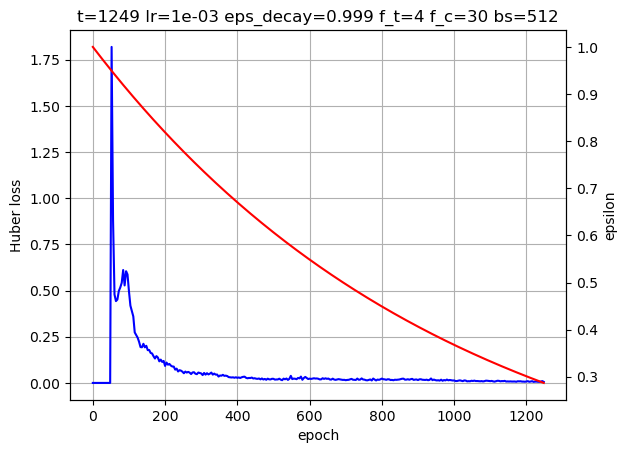

 50%|████▉     | 2499/5000 [03:54<10:47,  3.86it/s]

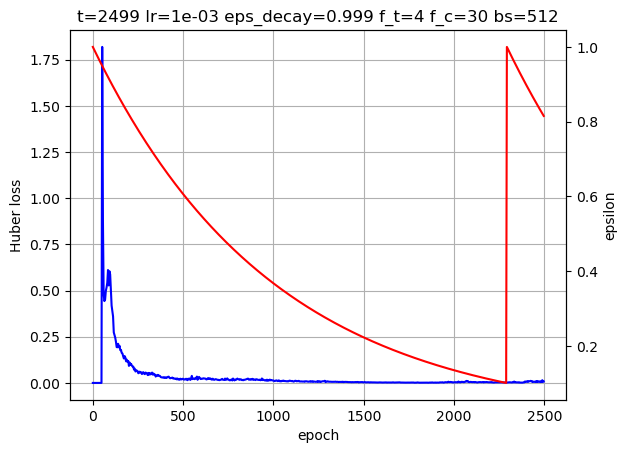

 75%|███████▍  | 3748/5000 [06:15<01:21, 15.30it/s]

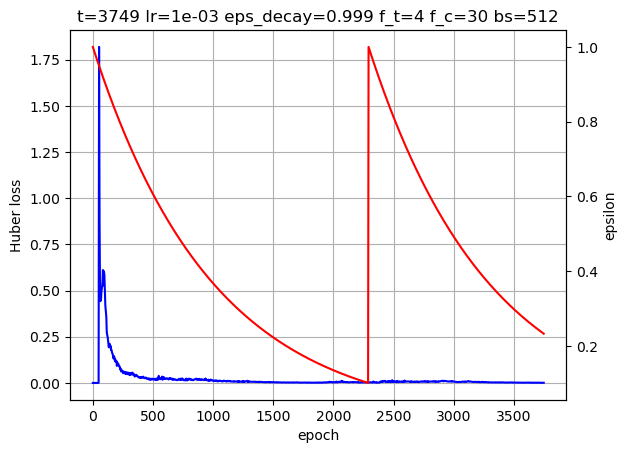

100%|█████████▉| 4998/5000 [07:39<00:00,  9.92it/s]

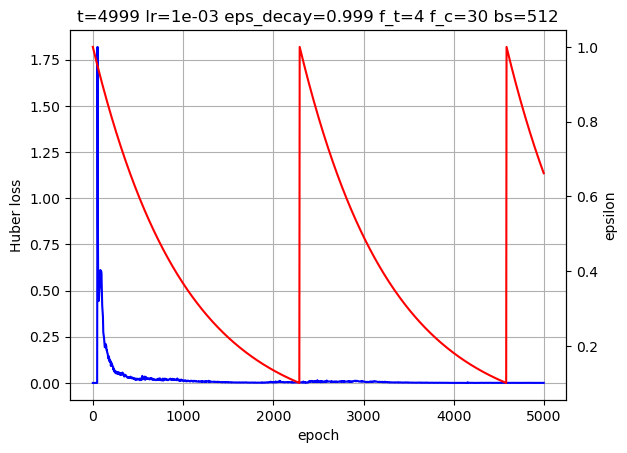

100%|██████████| 5000/5000 [07:40<00:00, 10.85it/s]


In [6]:
from datetime import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

losses = []
times = []
EPS = []
results = []
points = 0

for t in tqdm(range(epochs)):
    exp_list = play_exp_game(agent1, agent2, eps)
    replay_buffer.extend(exp_list)

    if not t % train_freq:
        loss = train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class)

        # if len(replay_buffer) > 10000:
        #     replay_buffer.clear_oldest(train_freq * len(exp_list))

        times.append(t)
        losses.append(loss)
        EPS.append(eps)

    if not t % target_update_freq:
        target_model.load_state_dict(main_model.state_dict())
                
    if not (t+1) % checkpoint_freq:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        path = rf'models/cp{t//checkpoint_freq}_{stamp}.pth'
        torch.save(main_model, path)

        plt.clf()
        plt.plot(times, losses, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("Huber loss")
        plt.grid()
        ax2 = plt.twinx()
        ax2.plot(times, EPS, 'r-')
        ax2.set_ylabel('epsilon')
        plt.title(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')
        plt.show()

    eps *= eps_decay
    if eps < eps_min + 0.001:
        eps = 1

In [7]:
main_model.state_dict()['conv1.weight'][0]

tensor([[[-0.0658,  0.0083,  0.0288, -0.0185],
         [ 0.0115, -0.0311,  0.0169,  0.0350],
         [-0.0118, -0.0287, -0.0627,  0.0019],
         [-0.0364,  0.0490,  0.0424,  0.0030]]])

In [8]:
replay_buffer.sample(1)

[(array([[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, -1,  0,  0,  0],
         [ 1,  0, -1, -1,  0,  0, -1],
         [ 1,  0,  1,  1,  0,  1, -1]], dtype=int8),
  1,
  1,
  array([[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, -1,  0,  0,  0],
         [ 1,  0, -1, -1,  0,  0, -1],
         [ 1,  0,  1,  1,  0,  1, -1]], dtype=int8),
  True)]

In [9]:
len(replay_buffer)

10000